In [25]:
import pandas as pd
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.manifold import TSNE
import umap
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib as mpl
from sklearn.utils import resample
import warnings
warnings.filterwarnings("ignore")
plt.rcParams['savefig.dpi'] = 300

In [14]:
# Load in dataset while taking into account ambigious features
train = pd.read_csv('train.csv')
drop_features = ['Over18', 'EmployeeCount', 'StandardHours', 'EmployeeID']
good_features = [c for c in train.columns if c not in drop_features]
ambiguous_features = ['Education', 'EnvironmentSatisfaction', 'JobInvolvement', 'JobLevel', 'JobSatisfaction', 'PerformanceRating', 'RelationshipSatisfaction', 'Shift', 'WorkLifeBalance']

numerical_features = list(set(train[good_features].select_dtypes(include=np.number).columns) - set(ambiguous_features))
categorical_features = [f for f in train.columns if f not in numerical_features and f not in drop_features]
catx_features = [f for f in categorical_features if f != 'Attrition']

train_dummies = pd.get_dummies(train[good_features], columns=categorical_features, drop_first=True)
# amb_train_dummies = pd.get_dummies(train_dummies, columns=ambiguous_features, drop_first=True)

train_y = train_dummies.Attrition_Yes
train_x = train_dummies.loc[:, train_dummies.columns != 'Attrition_Yes']
x_train, x_val, y_train, y_val = train_test_split(train_x, train_y, test_size = 0.25)

catxt_features = [f for f in train_x.columns if '_' in f]
numxt_features = [f for f in train_x if f not in catxt_features]

test_x_original = pd.read_csv('test.csv')
test_features = [c for c in good_features if c != 'Attrition']
test_cat = [c for c in categorical_features if c != 'Attrition']
test_x = pd.get_dummies(test_x_original[test_features], columns=test_cat, drop_first=True)

Text(0.5, 1.0, 'PCA Projection of Dataset')

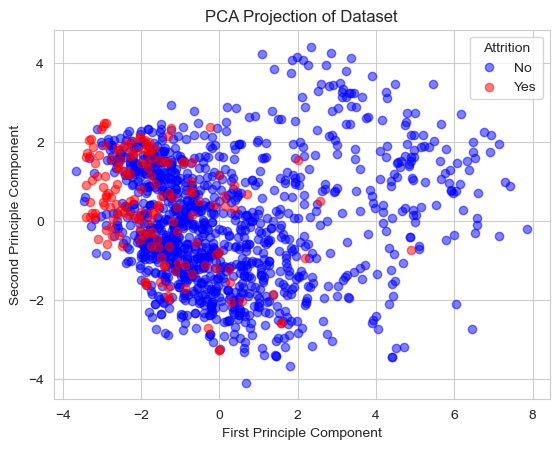

In [15]:
# Visualize data using PCA
x_train_scaled = StandardScaler().fit_transform(train_x)
x_pca = PCA(n_components=2).fit_transform(x_train_scaled)
plt.xlabel('First Principle Component')
plt.ylabel('Second Principle Component')
plt.scatter(x=x_pca[train_y == 0][:,0], y=x_pca[train_y == 0][:,1], c='blue', alpha=0.5, label='No')
plt.scatter(x=x_pca[train_y == 1][:,0], y=x_pca[train_y == 1][:,1], c='red', alpha=0.5, label='Yes')
plt.legend(title='Attrition')
plt.title("PCA Projection of Dataset")
# plt.savefig('Graphs/pcaall.png',bbox_inches='tight')

Text(0, 0.5, 'True Positive Rate')

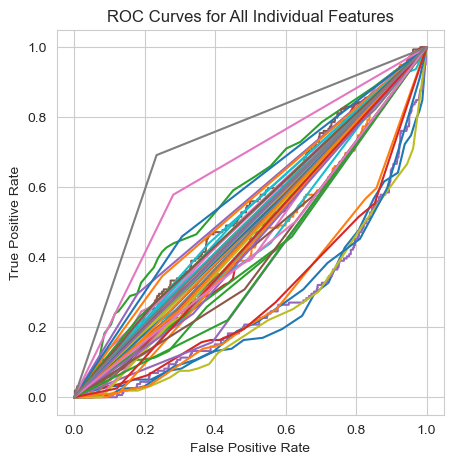

In [16]:
# Plot ROC Curves
auc_scores = []
plt.figure(figsize=(5,5))
for i, feature in enumerate(train_x.columns):
    fpr_train, tpr_train, thresholds_train = roc_curve(train_y, train_x[feature])
    auc_scores.append((feature, roc_auc_score(train_y, train_x[feature])))
    plt.plot(fpr_train, tpr_train, label=feature)
plt.title('ROC Curves for All Individual Features')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
# plt.savefig('Graphs/AllROC.png', bbox_inches='tight')

Text(0.5, 1.0, 'TSNE Projection of Data')

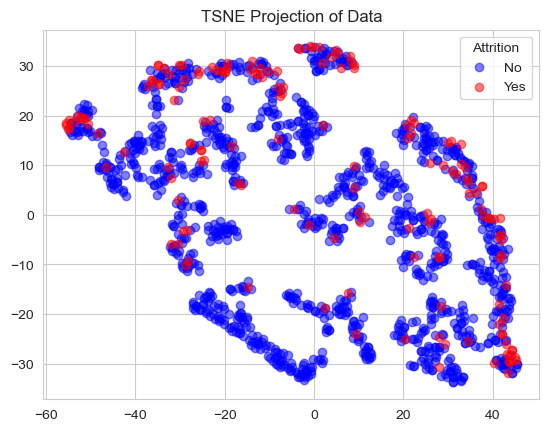

In [17]:
# Visualize data using TSNE
x_tsne = TSNE(perplexity=30).fit_transform(train_x)
plt.scatter(x=x_tsne[train_y == 0][:,0], y=x_tsne[train_y == 0][:,1], c='blue', alpha=0.5, label='No')
plt.scatter(x=x_tsne[train_y == 1][:,0], y=x_tsne[train_y == 1][:,1], c='red', alpha=0.5, label='Yes')
plt.legend(title='Attrition')
plt.title("TSNE Projection of Data")
# plt.savefig('Graphs/tsne2dp30.png')

Text(0.5, 1.0, 'UMAP Projection of Dataset')

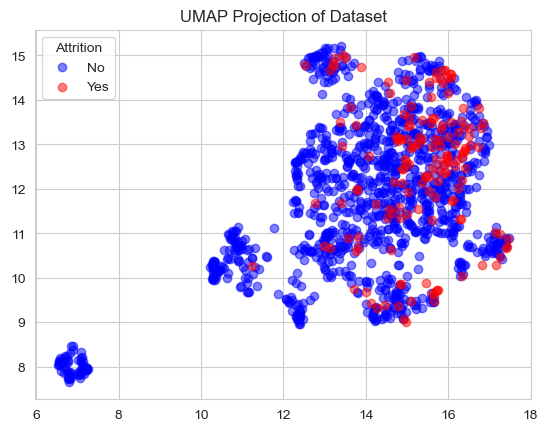

In [18]:
# Visualize data using UMAP
x_train_scaled = StandardScaler().fit_transform(train_x)
x_umap = umap.UMAP(n_neighbors=15).fit_transform(x_train_scaled)
plt.scatter(x=x_umap[train_y == 0][:,0], y=x_umap[train_y == 0][:,1], c='blue', alpha=0.5, label='No')
plt.scatter(x=x_umap[train_y == 1][:,0], y=x_umap[train_y == 1][:,1], c='red', alpha=0.5, label='Yes')
plt.legend(title='Attrition')
plt.title("UMAP Projection of Dataset")
# plt.savefig('Graphs/umap2dpdefault.png')

In [19]:
# Sort AUC scores, get sorted list of feature names and AUC values
auc_scores.sort(key=lambda x: max(0.5-x[1], x[1]-0.5), reverse=False)
auc_features = [x[0] for x in auc_scores]
auc_f_scores = [0.5 + max(0.5-x[1], x[1]-0.5) for x in auc_scores]

Text(0, 0.5, 'Feature')

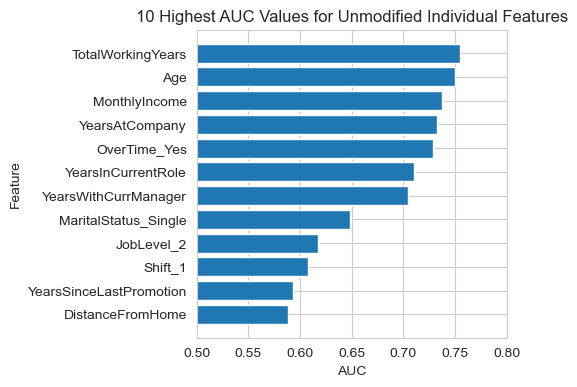

In [20]:
# Bar chart of individual features with greatest AUC values
plt.figure(figsize=(4,4))
plt.barh(auc_features[-12:], auc_f_scores[-12:])
plt.xlim(0.5,0.8)
plt.title('10 Highest AUC Values for Unmodified Individual Features')
plt.xlabel('AUC')
plt.ylabel('Feature')
# plt.savefig('Graphs/highauc.png', bbox_inches='tight')

Text(0, 0.5, 'Count')

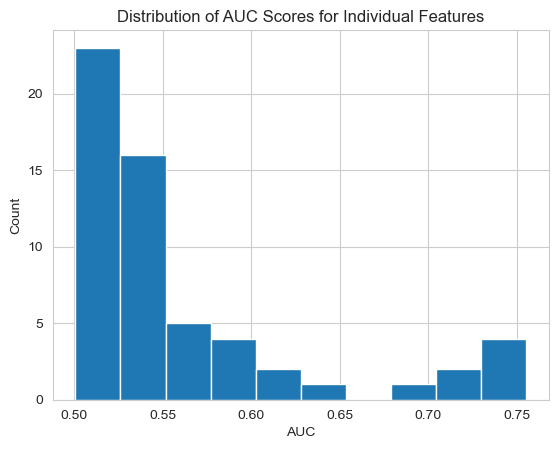

In [21]:
# Histogram of AUC values for individual features
plt.hist(auc_f_scores)
plt.title('Distribution of AUC Scores for Individual Features')
plt.xlabel('AUC')
plt.ylabel('Count')
# plt.savefig('Graphs/auchistogram.png', bbox_inches='tight')

In [22]:
# Create random up-sample training data
xyr = pd.concat([x_train, y_train], axis=1)
random_upsample = resample(xyr.loc[xyr.Attrition_Yes == 1], n_samples=len(xyr.loc[xyr.Attrition_Yes == 0]))
upsampled_df = pd.concat([random_upsample, xyr.loc[xyr.Attrition_Yes == 0]])
xr_train = upsampled_df.drop(columns='Attrition_Yes')
yr_train = upsampled_df.Attrition_Yes

In [23]:
# Generate PCA on training data
xr_train_scaled = StandardScaler().fit_transform(xr_train)
x_val_scaled = StandardScaler().fit_transform(x_val)

xr_train_pca = PCA(n_components=5).fit_transform(xr_train_scaled)
x_val_pca = PCA(n_components=5).fit_transform(x_val_scaled)

In [27]:
# Try to fit XGBoost model using PCA components
xgb_r_model = XGBClassifier(max_depth=7, verbosity=0).fit(xr_train_pca, yr_train)
f1_score(xgb_r_model.predict(x_val_pca), y_val)

0.2365591397849462